DATASET OVERVIEW
Samples: 1866
Features: 13
Time steps (records): 13632
Size: 2522.93 MB

FEATURE STATISTICS (across all samples & locations)
 0. Latitude     | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude    | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude     | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation in 3h | min:      -1.00 | max:    1049.70 | mean:       0.34
 9. Wind direction | min:       0.00 | max:     360.00 | mean:     174.47
10. Wind speed   | min:       0.00 | max:      37.70 | mean:       2.08
11. Maximum wind direction | min:  

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Unique Latitude values: 1234
Unique Longitude values: 1306
Altitude range: -47m to 4613m


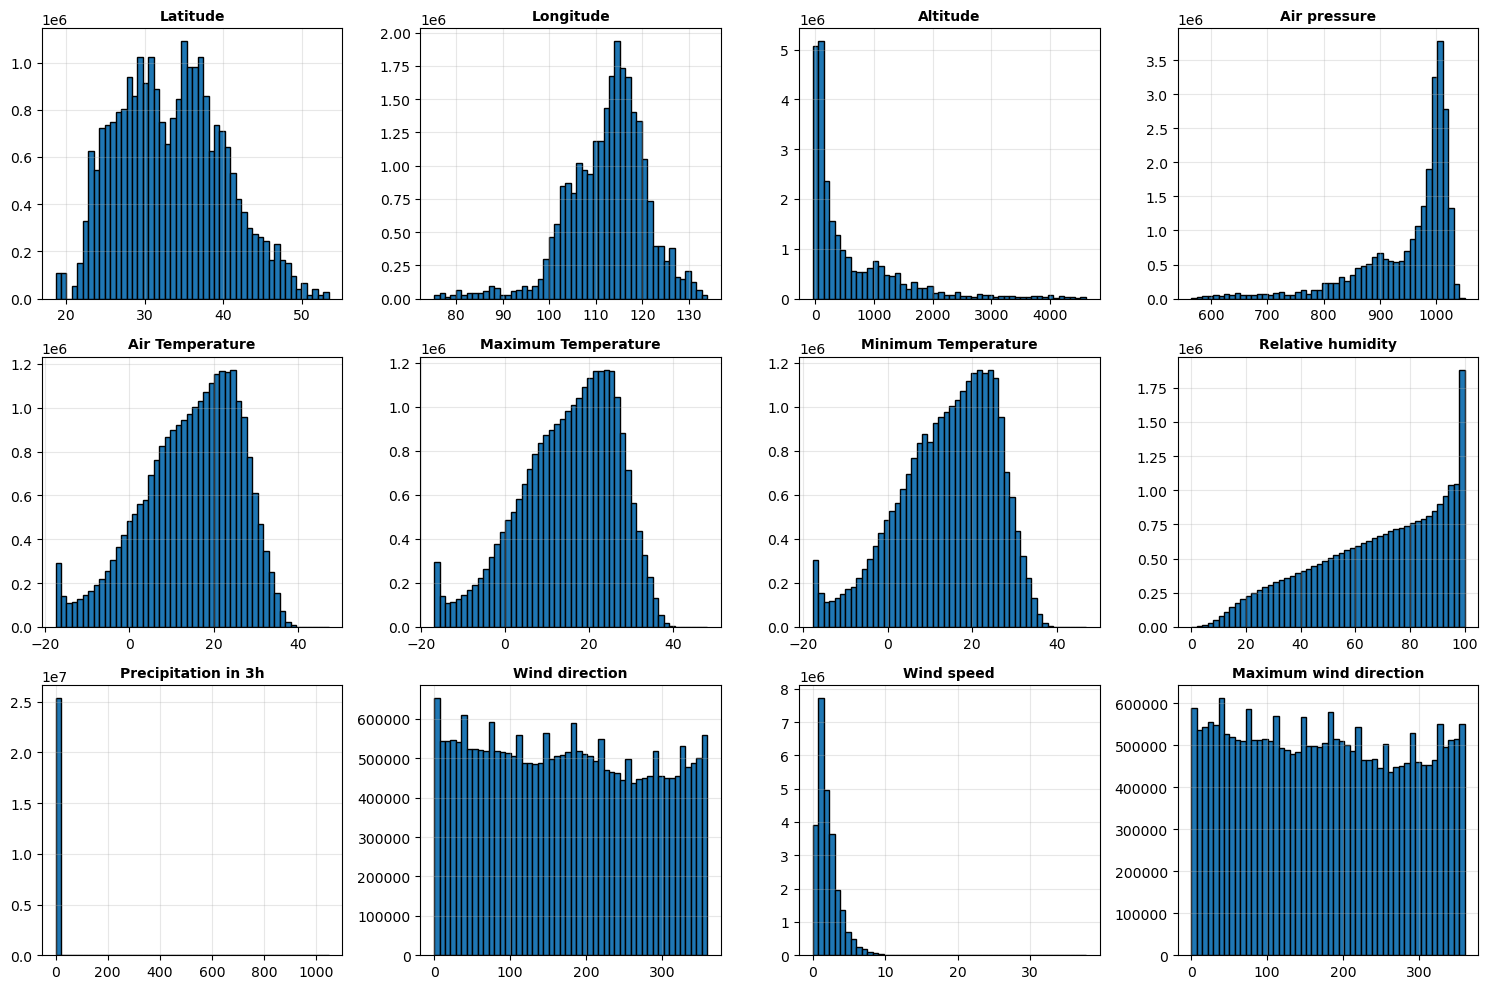

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os

# Load data
data = np.load(r"weather2k.npy", allow_pickle=True)

# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 'Precipitation in 3h', 
            'Wind direction', 'Wind speed', 'Maximum wind direction', 'Maximum wind speed']

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Samples: {data.shape[0]}")
print(f"Features: {data.shape[1]}")
print(f"Time steps (records): {data.shape[2]}")
print(f"Size: {data.nbytes / (1024**2):.2f} MB\n")

print("="*60)
print("FEATURE STATISTICS (across all samples & locations)")
print("="*60)
for i, fname in enumerate(features[:data.shape[1]]):
    feature_data = data[:, i, :]
    print(f"{i:2d}. {fname:12s} | min: {feature_data.min():10.2f} | "
          f"max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"NaN values: {np.isnan(data).sum()}")
print(f"Inf values: {np.isinf(data).sum()}")
print(f"Zero values: {(data == 0).sum()} ({(data == 0).sum() / data.size * 100:.2f}%)")

print("\n" + "="*60)
print("SAMPLE ANALYSIS")
print("="*60)
print(f"Sample 0 temp range: {data[0, 4, :].min():.1f}°C to {data[0, 4, :].max():.1f}°C")
print(f"Sample 0 humidity range: {data[0, 7, :].min():.1f}% to {data[0, 7, :].max():.1f}%")

# Visualize feature distributions
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(12, data.shape[1])):
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution.png', dpi=100)
print("\n✓ Saved feature distributions to 'weather_features_distribution.png'")

# Correlation analysis
print("\n" + "="*60)
print("FEATURE CORRELATIONS (sample 0)")
print("="*60)
sample_data = data[0, :, :].T  # Transpose to (locations, features)
corr_matrix = np.corrcoef(sample_data.T)

# Show strongest correlations
for i in range(min(5, data.shape[1])):
    for j in range(i+1, min(5, data.shape[1])):
        print(f"{features[i]:6s} vs {features[j]:6s}: {corr_matrix[i, j]:6.3f}")

print("\n" + "="*60)
print("SPATIAL ANALYSIS")
print("="*60)
print(f"Unique Latitude values: {len(np.unique(data[:, 0, :]))}")
print(f"Unique Longitude values: {len(np.unique(data[:, 1, :]))}")
print(f"Altitude range: {data[:, 2, :].min():.0f}m to {data[:, 2, :].max():.0f}m")

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
GPU: NVIDIA GeForce RTX 4060


In [3]:
# Check the original table more carefully
print(f"Total features in data: {data.shape[1]}")
print("\nChecking all features:")

for i in range(data.shape[1]):
    print(f"Index {i}: range [{data[:, i, :].min():.2f}, {data[:, i, :].max():.2f}]")

# Specifically check if 5 and 6 are both temperature-related
print("\n--- Temperature Analysis ---")
print(f"Index 5: {data[:, 5, :].min():.2f} to {data[:, 5, :].max():.2f}")
print(f"Index 6: {data[:, 6, :].min():.2f} to {data[:, 6, :].max():.2f}")

# Check if one is consistently higher (max) than the other (min)
sample_station = 0
sample_time = 100
print(f"\nSample comparison at station {sample_station}, time {sample_time}:")
print(f"Index 5: {data[sample_station, 5, sample_time]:.2f}")
print(f"Index 6: {data[sample_station, 6, sample_time]:.2f}")

Total features in data: 13

Checking all features:
Index 0: range [18.65, 53.47]
Index 1: range [75.25, 133.99]
Index 2: range [-47.20, 4613.00]
Index 3: range [564.90, 1050.00]
Index 4: range [-17.50, 47.20]
Index 5: range [-16.85, 48.10]
Index 6: range [-17.75, 46.90]
Index 7: range [0.00, 100.00]
Index 8: range [-1.00, 1049.70]
Index 9: range [0.00, 360.00]
Index 10: range [0.00, 37.70]
Index 11: range [0.00, 360.00]
Index 12: range [0.00, 48.90]

--- Temperature Analysis ---
Index 5: -16.85 to 48.10
Index 6: -17.75 to 46.90

Sample comparison at station 0, time 100:
Index 5: -14.90
Index 6: -15.30


In [4]:
# apply log transform to the precipitation
# Index 8 is precipitation column
PRECIP_IDX = 8

# Add small constant to avoid log(0), then log transform, the log transform would work because the column data is right-skewed data
data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)
print(f"Applied log transform to precipitation")

# Wind direction is circular - convert to sin/cos
# Indices 9 and 11 are wind directions
WD_INDICES = [9, 11]

for wd_idx in WD_INDICES:
    # Convert degrees to radians, then to sin/cos
    rad = np.deg2rad(data[:, wd_idx, :])
    sin_component = np.sin(rad)
    cos_component = np.cos(rad)
    
    # Replace original with sin, append cos as new feature
    data[:, wd_idx, :] = sin_component
    # Add cos component as new feature
    cos_feature = cos_component[np.newaxis, :, :]  # Add feature dimension
    data = np.concatenate([data, cos_feature.transpose(1, 0, 2)], axis=1)

print(f"Converted wind directions to sin/cos. New shape: {data.shape}")

Applied log transform to precipitation


C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\2054478675.py:6: RuntimeWarning: divide by zero encountered in log1p
  data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)


Converted wind directions to sin/cos. New shape: (1866, 15, 13632)


In [5]:
# Original feature names
features = [
    "Latitude", "Longitude", "Altitude", "Air pressure", "Air Temperature",
    "Maximum Temperature", "Minimum Temperature", "Relative humidity",
    "Precipitation", "Wind direction", "Wind speed", "Max wind dir", "Max wind speed"
]

# Add cos features for wind directions
for idx in WD_INDICES:
    features.append(f"{features[idx]}_cos")

print("New feature names:")
# Compute min, max, mean for all features
print("\nFEATURE STATS (with new cos features)")
for i, f in enumerate(features):
    feature_data = data[:, i, :].flatten()
    print(f"{i:2d}. {f:25s} | min: {feature_data.min():10.2f} | max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

New feature names:

FEATURE STATS (with new cos features)
 0. Latitude                  | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude                 | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude                  | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure              | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature           | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature       | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature       | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity         | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation             | min:       -inf | max:       6.96 | mean:       -inf
 9. Wind direction            | min:      -1.00 | max:       1.00 | mean:       0.03
10. Wind speed                | min:       0.00 | max:      37.70 | mean:       2.08
11. Max

In [6]:
print(f"Shape: {data.shape}")

# Check for NaN/Inf values
nan_count = np.isnan(data).sum()
inf_count = np.isinf(data).sum()
print(f"NaN values: {nan_count}, Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    for i in range(data.shape[1]):
        feature = data[:, i, :]
        # Calculate median only on finite values
        valid_mask = np.isfinite(feature)
        if valid_mask.any():
            median_val = np.median(feature[valid_mask])
        else:
            median_val = 0.0
        
        # Replace NaN and Inf with median
        data[:, i, :] = np.where(np.isfinite(feature), feature, median_val)
    
    print("Replaced NaN/Inf with median values")
    print(f"After fix - NaN: {np.isnan(data).sum()}, Inf: {np.isinf(data).sum()}")

Shape: (1866, 15, 13632)
NaN values: 0, Inf values: 3645
Replaced NaN/Inf with median values
After fix - NaN: 0, Inf: 0


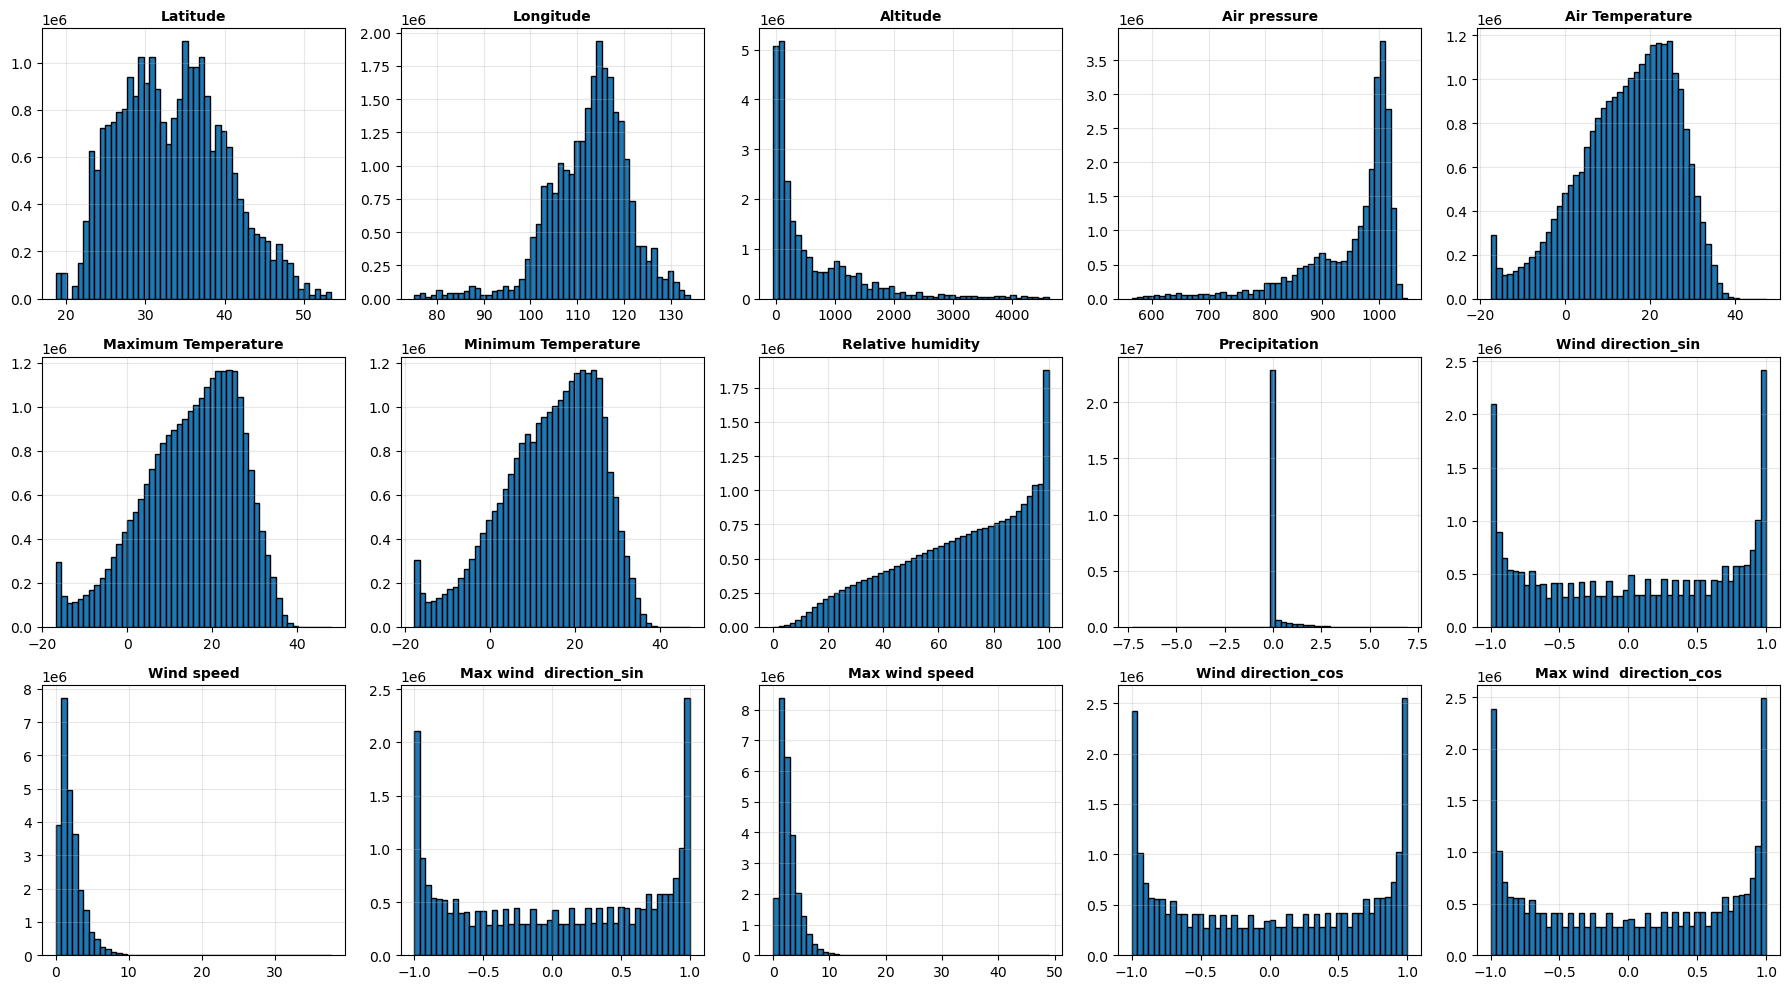

In [7]:
# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 
            'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 
            'Precipitation', 'Wind direction_sin', 'Wind speed', 
            'Max wind  direction_sin', 'Max wind speed', 'Wind direction_cos', 
            'Max wind  direction_cos']

# Visualize feature distributions
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i in range(data.shape[1]):  # All 15 features
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution_after_preprocessing.png', dpi=100)
plt.show()

In [8]:
# Temporal split
n_timesteps = data.shape[2]  # 13632
n_train = int(0.7 * n_timesteps)
n_val = int(0.15 * n_timesteps)

train_data = data[:, :, :n_train]
val_data = data[:, :, n_train:n_train+n_val]
test_data = data[:, :, n_train+n_val:]

print(f"Train timesteps: {train_data.shape[2]}")
print(f"Val timesteps: {val_data.shape[2]}")
print(f"Test timesteps: {test_data.shape[2]}")

# Fit scaler on train data: (stations*timesteps, features)
train_flat = train_data.reshape(-1, train_data.shape[1])  # Flatten stations and timesteps
scaler = StandardScaler()
scaler.fit(train_flat)

def normalize_data(data, scaler):
    """Normalize data using fitted scaler"""
    n_stations, n_features, n_timesteps = data.shape
    data_flat = data.reshape(-1, n_features)  # (stations*timesteps, features)
    data_normalized = scaler.transform(data_flat)
    return data_normalized.reshape(n_stations, n_features, n_timesteps)

train_norm = normalize_data(train_data, scaler)
val_norm = normalize_data(val_data, scaler)
test_norm = normalize_data(test_data, scaler)

Train timesteps: 9542
Val timesteps: 2044
Test timesteps: 2046


In [9]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, pred_horizon, slide_step, target_idxs):
        """
        Args:
            data: (n_stations, n_features, n_timesteps)
            seq_len: input sequence length
            pred_horizon: number of future timesteps to predict
            slide_step: sliding window step size
            target_idxs: index of target feature (mxt/mnt)
        """
        self.data = data
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.slide_step = slide_step
        self.target_idxs = target_idxs
        
        # Generate all valid window indices
        self.samples = []
        n_stations, n_features, n_timesteps = data.shape
        
        for station_idx in range(n_stations):
            for start_idx in range(0, n_timesteps - seq_len - pred_horizon + 1, slide_step):
                end_idx = start_idx + seq_len
                self.samples.append((station_idx, start_idx, end_idx))
        
        print(f"Created {len(self.samples)} windows")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        station_idx, start_idx, end_idx = self.samples[idx]
        
        # Input: all features for seq_len timesteps
        X = self.data[station_idx, :, start_idx:end_idx]  # (n_features, seq_len)
        
        # Target: only mxt/mnt for next pred_horizon timesteps
        y = self.data[station_idx, self.target_idxs, end_idx:end_idx + self.pred_horizon]
        
        return torch.FloatTensor(X), torch.FloatTensor(y) # both (n_features, seq_len)

In [ ]:
SEQ_LEN = 84      # 10.5 days
PRED_HORIZON = 8   # Predict next 8 timesteps (24 hours)
SLIDE_STEP = 8    # Slide by 56 steps (168 hours / 1 week)
TARGET_IDXS = [4, 5, 6, 8]

In [34]:
train_dataset = WeatherDataset(train_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
val_dataset = WeatherDataset(val_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
test_dataset = WeatherDataset(test_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)

Created 2205612 windows
Created 457170 windows
Created 457170 windows


In [36]:
BATCH_SIZE = 512 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nDataLoader Info:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoader Info:
Train batches: 4308
Val batches: 893
Test batches: 893


In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) # positional encoding matrix, each row corresponds to a position, each column to a dimension of the embedding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # (max_len, 1)

        # computing the caling factors for each embedding dimension
        # torch.arange(0, d_model, 2), selects every even dimension.
        # (-np.log(10000.0) / d_model), controls the frequency range of sine/cosine.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Fill positional encoding matrix multiplying with sine for the even indices and cosine for odd ones
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

In [38]:
class WeatherTransformer(nn.Module):
    def __init__(self, n_features, d_model, nhead, num_layers, dim_feedforward, 
                 pred_horizon, n_targets, dropout=0.1):
        
        # d_model: the hidden size (size of the input/output of the Transformer layer)
        # nhead is the number of attention layers in the multi-head attention layer
        # num_layers is the number of stacked Transformer encoder layers (depth of the model)
        # dim_feedforward is the hidden size of the feedforward network

        # so one layer = attention + feedforward + normalization. Stacking num_layers repeats this

        super().__init__()
        
        self.n_features = n_features
        self.d_model = d_model
        self.pred_horizon = pred_horizon
        self.n_targets = n_targets
        
        # Input projection: (batch, seq_len, n_features) -> (batch, seq_len, d_model)
        self.input_projection = nn.Linear(n_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True # means batch first in the input shape
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection: predict n_targets for pred_horizon timesteps
        self.output_projection = nn.Linear(d_model, pred_horizon * n_targets)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: (batch, n_features, seq_len)
        x = x.transpose(1, 2)  # -> (batch, seq_len, n_features)
        
        # Project to d_model
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = self.dropout(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Use last timestep representation (which is the final output summary of the transformer)
        x = x[:, -1, :]  # (batch, d_model)
        
        # Project to output
        out = self.output_projection(x)  # (batch, pred_horizon * n_targets)
        out = out.view(-1, self.n_targets, self.pred_horizon)  # (batch, n_targets, pred_horizon)
        
        return out

In [40]:
# Model hyperparameters
N_FEATURES = 15
D_MODEL = 128
NHEAD = 8
NUM_LAYERS = 4
DIM_FEEDFORWARD = 512
N_TARGETS = 4  # Air Temp, Max Temp, Min Temp, Precipitation
DROPOUT = 0.1

# Initialize model
model = WeatherTransformer(
    n_features=N_FEATURES,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    pred_horizon=PRED_HORIZON,
    n_targets=N_TARGETS,
    dropout=DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print(f"MODEL SUMMARY")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / (1024**2):.2f} MB")


MODEL SUMMARY
Total parameters: 799,264
Trainable parameters: 799,264
Model size: ~3.05 MB


In [57]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.01)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)

print("\nOptimizer: AdamW (lr=1e-4, weight_decay=1e-5)")
print("Scheduler: StepLR (step_size=10, gamma=0.65)")
print("Loss: MSE")


Optimizer: AdamW (lr=1e-4, weight_decay=1e-5)
Scheduler: StepLR (step_size=10, gamma=0.65)
Loss: MSE


In [64]:
from torch.amp import autocast, GradScaler

# Mixed precision scaler
scaler = GradScaler()

print(f"Using mixed precision training (AMP)")

Using mixed precision training (AMP)


In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    """Calculate RMSE, MAE, R2 for each target"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    n_targets = y_true.shape[1]
    metrics = {}
    
    for i in range(n_targets):
        true_flat = y_true[:, i, :].flatten()
        pred_flat = y_pred[:, i, :].flatten()
        
        rmse = np.sqrt(mean_squared_error(true_flat, pred_flat))
        mae = mean_absolute_error(true_flat, pred_flat)
        r2 = r2_score(true_flat, pred_flat)
        
        metrics[f'target_{i}'] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    
    # Overall averages
    metrics['avg'] = {
        'rmse': np.mean([metrics[f'target_{i}']['rmse'] for i in range(n_targets)]),
        'mae': np.mean([metrics[f'target_{i}']['mae'] for i in range(n_targets)]),
        'r2': np.mean([metrics[f'target_{i}']['r2'] for i in range(n_targets)])
    }
    
    return metrics

In [45]:
os.makedirs('statistics', exist_ok=True)
os.makedirs('transformer_models', exist_ok=True)

# Initialize metrics file with header
with open('statistics/transformer_training_metrics.txt', 'w') as f:
    f.write("Epoch,Time(s),Train_Loss,Val_Loss,LR,Train_RMSE,Train_MAE,Train_R2,Val_RMSE,Val_MAE,Val_R2\n")

print("Created directories and metrics file")

Created directories and metrics file


In [72]:
def train_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast('cuda'):
            output = model(X)
            loss = criterion(output, y)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        all_preds.append(output.detach())
        all_targets.append(y.detach())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    metrics = calculate_metrics(all_targets, all_preds)
    
    return total_loss / len(loader), metrics

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            with autocast('cuda'):
                output = model(X)
                loss = criterion(output, y)
            
            total_loss += loss.item()
            all_preds.append(output)
            all_targets.append(y)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    metrics = calculate_metrics(all_targets, all_preds)
    
    return total_loss / len(loader), metrics

In [ ]:
epoch = 1

In [ ]:
def train(epochs):
    global epoch
    global best_val_loss
    print(f"\n{'='*80}")
    print(f"STARTING TRAINING - {epochs} EPOCHS")
    print(f"{'='*80}\n")

    for i in range(1, epochs + 1):
        epoch_start = time.time()
        
        # Train
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        
        # Validate
        val_loss, val_metrics = validate(model, val_loader, criterion, device)
        
        # Scheduler step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        epoch_time = time.time() - epoch_start
        
        # Print metrics
        print(f"Epoch {epoch} | Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.2e}")
        print(f"  Train - RMSE: {train_metrics['avg']['rmse']:.4f} | MAE: {train_metrics['avg']['mae']:.4f} | R2: {train_metrics['avg']['r2']:.4f}")
        print(f"  Val   - RMSE: {val_metrics['avg']['rmse']:.4f} | MAE: {val_metrics['avg']['mae']:.4f} | R2: {val_metrics['avg']['r2']:.4f}")
        print()
        
        # Save metrics to file
        with open('statistics/transformer_training_metrics.txt', 'a') as f:
            f.write(f"{epoch},{epoch_time:.2f},{train_loss:.6f},{val_loss:.6f},{current_lr:.2e},"
                    f"{train_metrics['avg']['rmse']:.4f},{train_metrics['avg']['mae']:.4f},{train_metrics['avg']['r2']:.4f},"
                    f"{val_metrics['avg']['rmse']:.4f},{val_metrics['avg']['mae']:.4f},{val_metrics['avg']['r2']:.4f}\n")
        
        # Save model after epoch 5
        if epoch >= 5:
            torch.save(model.state_dict(), f"transformer_models/model_epoch_{epoch}.pt")
        
            
        epoch += 1

    print(f"\n{'='*80}")
    print(f"TRAINING COMPLETE")
    print(f"{'='*80}")    

In [56]:
train(10)


STARTING TRAINING - 10 EPOCHS



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 360.80s
  Train Loss: 0.000076 | Val Loss: 0.000125 | LR: 1.00e-03
  Train - RMSE: 0.0081 | MAE: 0.0063 | R2: -0.0622
  Val   - RMSE: 0.0101 | MAE: 0.0079 | R2: 0.2817



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 363.79s
  Train Loss: 0.000054 | Val Loss: 0.000120 | LR: 1.00e-03
  Train - RMSE: 0.0068 | MAE: 0.0052 | R2: 0.4054
  Val   - RMSE: 0.0099 | MAE: 0.0077 | R2: 0.4120



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 372.12s
  Train Loss: 0.000044 | Val Loss: 0.000116 | LR: 1.00e-03
  Train - RMSE: 0.0060 | MAE: 0.0046 | R2: 0.5991
  Val   - RMSE: 0.0097 | MAE: 0.0076 | R2: 0.5179



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 367.94s
  Train Loss: 0.000039 | Val Loss: 0.000109 | LR: 1.00e-03
  Train - RMSE: 0.0057 | MAE: 0.0043 | R2: 0.6707
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.5424



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 365.86s
  Train Loss: 0.000037 | Val Loss: 0.000107 | LR: 1.00e-03
  Train - RMSE: 0.0055 | MAE: 0.0041 | R2: 0.6843
  Val   - RMSE: 0.0093 | MAE: 0.0071 | R2: 0.5821



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 375.35s
  Train Loss: 0.000035 | Val Loss: 0.000102 | LR: 1.00e-03
  Train - RMSE: 0.0054 | MAE: 0.0040 | R2: 0.6959
  Val   - RMSE: 0.0091 | MAE: 0.0070 | R2: 0.5791



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 366.00s
  Train Loss: 0.000034 | Val Loss: 0.000104 | LR: 1.00e-03
  Train - RMSE: 0.0053 | MAE: 0.0039 | R2: 0.7011
  Val   - RMSE: 0.0092 | MAE: 0.0072 | R2: 0.5343



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 338.14s
  Train Loss: 0.000033 | Val Loss: 0.000098 | LR: 1.00e-03
  Train - RMSE: 0.0052 | MAE: 0.0039 | R2: 0.7059
  Val   - RMSE: 0.0089 | MAE: 0.0069 | R2: 0.5838



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 336.63s
  Train Loss: 0.000031 | Val Loss: 0.000102 | LR: 1.00e-03
  Train - RMSE: 0.0051 | MAE: 0.0038 | R2: 0.7094
  Val   - RMSE: 0.0091 | MAE: 0.0069 | R2: 0.5639



C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\1487057614.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Time: 336.11s
  Train Loss: 0.000030 | Val Loss: 0.000106 | LR: 1.00e-03
  Train - RMSE: 0.0050 | MAE: 0.0037 | R2: 0.7136
  Val   - RMSE: 0.0093 | MAE: 0.0071 | R2: 0.6011


TRAINING COMPLETE
Best validation loss: 0.000098, achieved at epoch 1


In [68]:
train(5) # another 5 epochs starting from epoch 12


STARTING TRAINING - 5 EPOCHS



c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12 | Time: 366.29s
  Train Loss: 0.000028 | Val Loss: 0.000107 | LR: 6.00e-04
  Train - RMSE: 0.0048 | MAE: 0.0036 | R2: 0.7290
  Val   - RMSE: 0.0093 | MAE: 0.0071 | R2: 0.5904



c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 13 | Time: 359.62s
  Train Loss: 0.000027 | Val Loss: 0.000110 | LR: 6.00e-04
  Train - RMSE: 0.0047 | MAE: 0.0035 | R2: 0.7323
  Val   - RMSE: 0.0094 | MAE: 0.0074 | R2: 0.5731



KeyboardInterrupt: 

In [ ]:
# Decreasing the lr even more

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.73)

In [75]:
# 5 ephocs starting from 14
train(5)


STARTING TRAINING - 5 EPOCHS

Epoch 14 | Time: 367.74s
  Train Loss: 0.000024 | Val Loss: 0.000105 | LR: 1.00e-04
  Train - RMSE: 0.0045 | MAE: 0.0033 | R2: 0.7509
  Val   - RMSE: 0.0092 | MAE: 0.0071 | R2: 0.6010

Epoch 15 | Time: 346.69s
  Train Loss: 0.000024 | Val Loss: 0.000109 | LR: 1.00e-04
  Train - RMSE: 0.0045 | MAE: 0.0033 | R2: 0.7517
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.5959

Epoch 16 | Time: 340.96s
  Train Loss: 0.000023 | Val Loss: 0.000109 | LR: 7.30e-05
  Train - RMSE: 0.0044 | MAE: 0.0033 | R2: 0.7522
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.5970

Epoch 17 | Time: 342.82s
  Train Loss: 0.000023 | Val Loss: 0.000111 | LR: 7.30e-05
  Train - RMSE: 0.0044 | MAE: 0.0032 | R2: 0.7538
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.5963

Epoch 18 | Time: 343.35s
  Train Loss: 0.000023 | Val Loss: 0.000110 | LR: 7.30e-05
  Train - RMSE: 0.0044 | MAE: 0.0032 | R2: 0.7540
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.6013


TRAINING COMPLETE


UnboundLocalError: cannot access local variable 'best_val_loss_epoch' where it is not associated with a value

In [78]:
train(5)


STARTING TRAINING - 5 EPOCHS

Epoch 19 | Time: 340.40s
  Train Loss: 0.000023 | Val Loss: 0.000107 | LR: 5.33e-05
  Train - RMSE: 0.0044 | MAE: 0.0032 | R2: 0.7544
  Val   - RMSE: 0.0093 | MAE: 0.0072 | R2: 0.6066

Epoch 20 | Time: 337.06s
  Train Loss: 0.000022 | Val Loss: 0.000110 | LR: 5.33e-05
  Train - RMSE: 0.0043 | MAE: 0.0032 | R2: 0.7555
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.5980

Epoch 21 | Time: 338.14s
  Train Loss: 0.000022 | Val Loss: 0.000109 | LR: 5.33e-05
  Train - RMSE: 0.0043 | MAE: 0.0032 | R2: 0.7557
  Val   - RMSE: 0.0093 | MAE: 0.0073 | R2: 0.6029

Epoch 22 | Time: 353.92s
  Train Loss: 0.000022 | Val Loss: 0.000110 | LR: 3.89e-05
  Train - RMSE: 0.0043 | MAE: 0.0032 | R2: 0.7560
  Val   - RMSE: 0.0094 | MAE: 0.0073 | R2: 0.6023

Epoch 23 | Time: 373.25s
  Train Loss: 0.000022 | Val Loss: 0.000112 | LR: 3.89e-05
  Train - RMSE: 0.0043 | MAE: 0.0032 | R2: 0.7567
  Val   - RMSE: 0.0095 | MAE: 0.0073 | R2: 0.6020


TRAINING COMPLETE


NameError: name 'best_val_loss_epoch' is not defined

In [80]:
# load the best model
model.load_state_dict(torch.load("transformer_models/model_epoch_19.pt"))
print("Loaded model from epoch 19")

Loaded model from epoch 19


C:\Users\mamou\AppData\Local\Temp\ipykernel_35364\3871845600.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_models/model_e

In [81]:
model.eval()

# Evaluate on test set
test_loss, test_metrics = validate(model, test_loader, criterion, device)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test RMSE: {test_metrics['avg']['rmse']:.4f}")
print(f"Test MAE: {test_metrics['avg']['mae']:.4f}")
print(f"Test R2: {test_metrics['avg']['r2']:.4f}")
print()
print("Per-target metrics:")
target_names = ['Air Temp', 'Max Temp', 'Min Temp', 'Precipitation']
for i, name in enumerate(target_names):
    m = test_metrics[f'target_{i}']
    print(f"  {name:15s} - RMSE: {m['rmse']:.4f} | MAE: {m['mae']:.4f} | R2: {m['r2']:.4f}")


TEST SET RESULTS
Test Loss: 0.000138
Test RMSE: 0.0105
Test MAE: 0.0085
Test R2: 0.6399

Per-target metrics:
  Air Temp        - RMSE: 0.0136 | MAE: 0.0112 | R2: 0.8364
  Max Temp        - RMSE: 0.0136 | MAE: 0.0112 | R2: 0.8371
  Min Temp        - RMSE: 0.0135 | MAE: 0.0110 | R2: 0.8403
  Precipitation   - RMSE: 0.0012 | MAE: 0.0006 | R2: 0.0457


In [82]:
import pandas as pd

# Load training history
df_metrics = pd.read_csv('statistics/transformer_training_metrics.txt')
print(f"\nLoaded {len(df_metrics)} epochs from file")


Loaded 23 epochs from file


Saved training curves to 'statistics/training_curves.png'


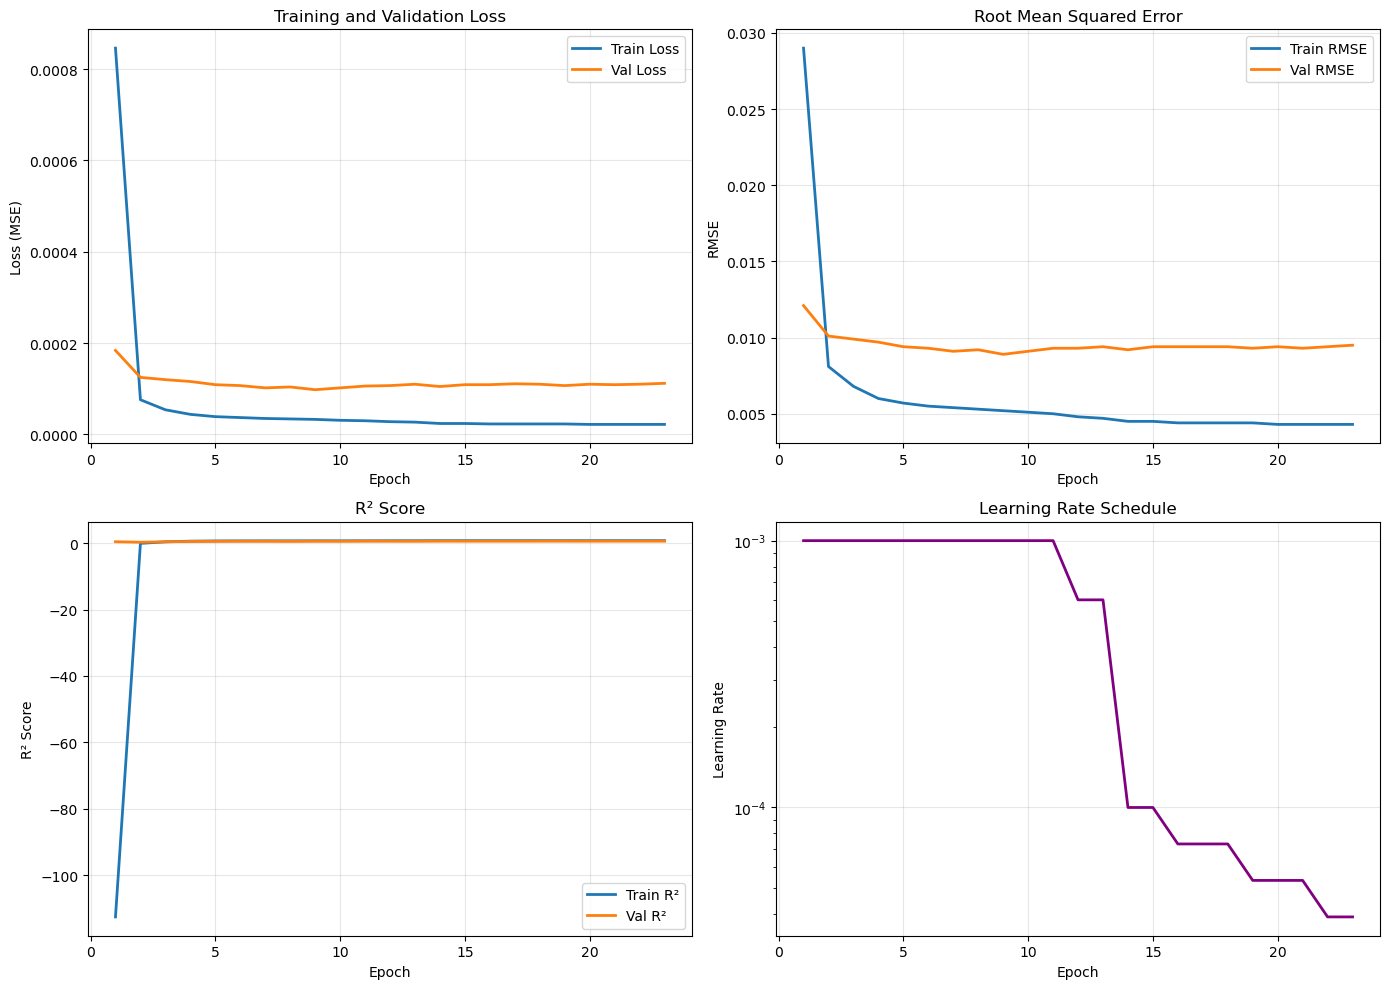

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
axes[0, 0].plot(df_metrics['Epoch'], df_metrics['Train_Loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(df_metrics['Epoch'], df_metrics['Val_Loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# RMSE
axes[0, 1].plot(df_metrics['Epoch'], df_metrics['Train_RMSE'], label='Train RMSE', linewidth=2)
axes[0, 1].plot(df_metrics['Epoch'], df_metrics['Val_RMSE'], label='Val RMSE', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Root Mean Squared Error')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# R2 Score
axes[1, 0].plot(df_metrics['Epoch'], df_metrics['Train_R2'], label='Train R²', linewidth=2)
axes[1, 0].plot(df_metrics['Epoch'], df_metrics['Val_R2'], label='Val R²', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Learning Rate
axes[1, 1].plot(df_metrics['Epoch'], df_metrics['LR'], linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('statistics/training_curves.png', dpi=150)
print("Saved training curves to 'statistics/training_curves.png'")
plt.show()

In [85]:
# Get predictions on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        with autocast('cuda'):
            output = model(X)
        all_preds.append(output.cpu())
        all_targets.append(y)

all_preds = torch.cat(all_preds, dim=0).numpy()  # (samples, 4_targets, 8_horizon)
all_targets = torch.cat(all_targets, dim=0).numpy()

print(f"Generated predictions: {all_preds.shape}")

Generated predictions: (457170, 4, 8)


Saved predictions plot to 'statistics/predictions_vs_actual.png'


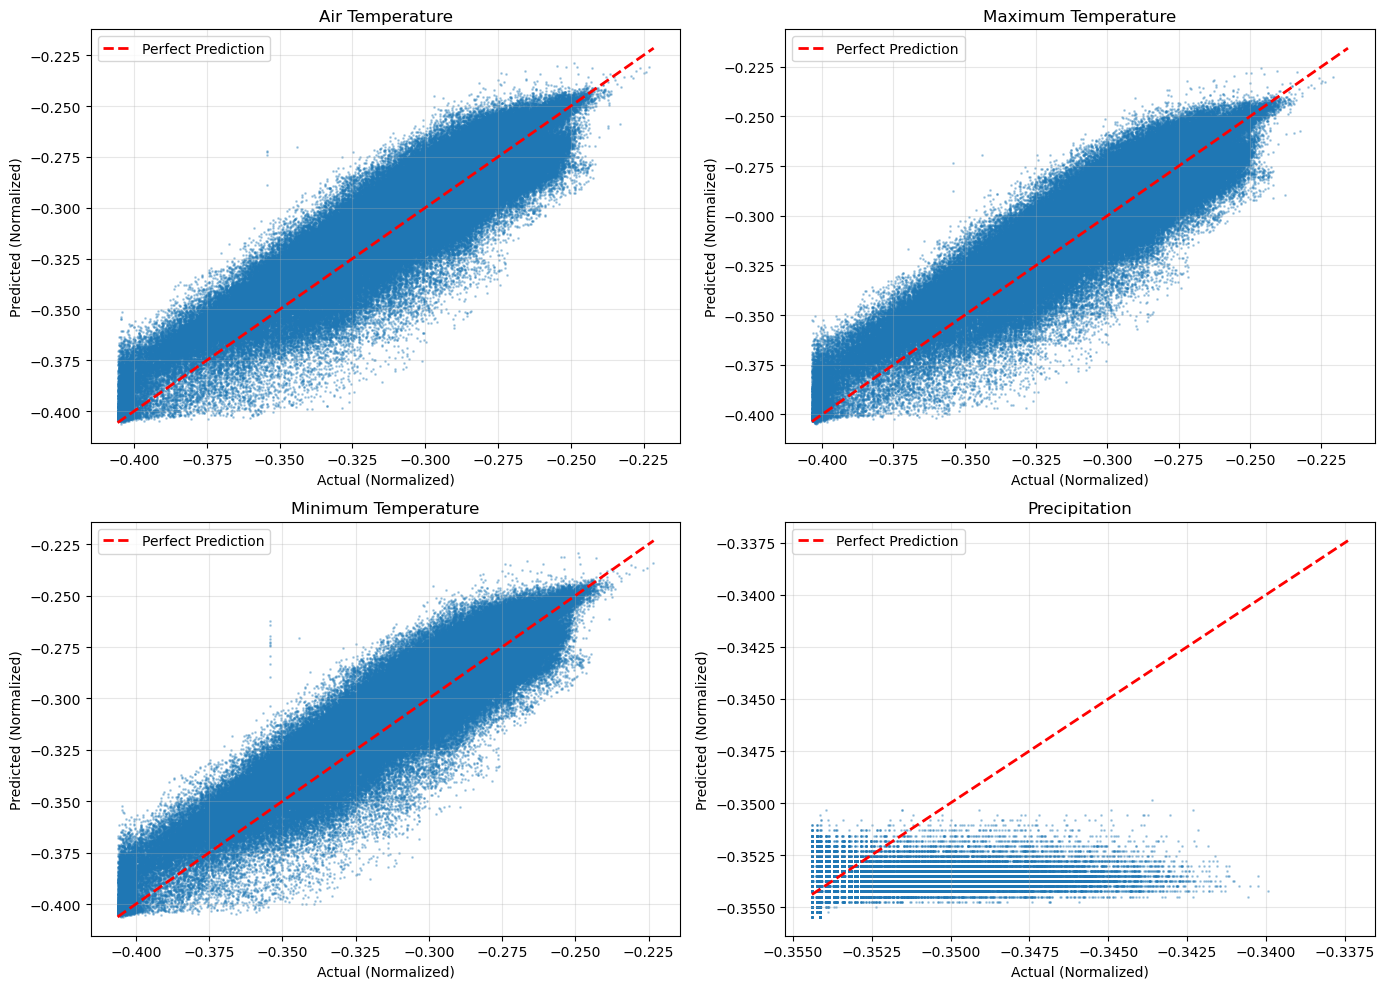

In [86]:
# Plot predictions vs actual for each target
target_names = ['Air Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Precipitation']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, name in enumerate(target_names):
    # Flatten across all samples and horizons
    pred_flat = all_preds[:, i, :].flatten()
    true_flat = all_targets[:, i, :].flatten()
    
    # Sample for faster plotting (use every 10th point)
    sample_idx = np.arange(0, len(pred_flat), 10)
    
    axes[i].scatter(true_flat[sample_idx], pred_flat[sample_idx], alpha=0.3, s=1)
    axes[i].plot([true_flat.min(), true_flat.max()], 
                 [true_flat.min(), true_flat.max()], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[i].set_xlabel('Actual (Normalized)')
    axes[i].set_ylabel('Predicted (Normalized)')
    axes[i].set_title(f'{name}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('statistics/predictions_vs_actual.png', dpi=150)
print("Saved predictions plot to 'statistics/predictions_vs_actual.png'")
plt.show()